In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, confusion_matrix

# Load the Excel files
email_df = pd.read_csv("email_table.csv")
opened_df = pd.read_csv("email_opened_table.csv")
clicked_df = pd.read_csv("link_clicked_table.csv")

# Initial inspection
print(email_df.head())
print(opened_df.head())
print(clicked_df.head())

   email_id   email_text email_version  hour    weekday user_country  \
0     85120  short_email  personalized     2     Sunday           US   
1    966622   long_email  personalized    12     Sunday           UK   
2    777221   long_email  personalized    11  Wednesday           US   
3    493711  short_email       generic     6     Monday           UK   
4    106887   long_email       generic    14     Monday           US   

   user_past_purchases  
0                    5  
1                    2  
2                    2  
3                    1  
4                    6  
   email_id
0    284534
1    609056
2    220820
3    905936
4    164034
   email_id
0    609056
1    870980
2    935124
3    158501
4    177561


In [4]:
#1. What percentage of users opened the email and clicked the link?
total_emails = email_df.shape[0]
opened_count = opened_df['email_id'].nunique()
clicked_count = clicked_df['email_id'].nunique()

open_rate = opened_count / total_emails * 100
click_rate = clicked_count / total_emails * 100

print(f"Open Rate: {open_rate:.2f}%")
print(f"Click Rate: {click_rate:.2f}%")


Open Rate: 10.35%
Click Rate: 2.12%


In [5]:
#2. Build a model to predict clicks
# Add target columns
email_df['is_opened'] = email_df['email_id'].isin(opened_df['email_id']).astype(int)
email_df['is_clicked'] = email_df['email_id'].isin(clicked_df['email_id']).astype(int)

# One-hot encode categorical features
email_df_encoded = pd.get_dummies(email_df, columns=['email_text', 'email_version', 'weekday', 'user_country'])

# Drop unused columns
X = email_df_encoded.drop(columns=['email_id', 'is_opened', 'is_clicked'])
y = email_df_encoded['is_clicked']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

# Evaluation
print("Accuracy:", accuracy_score(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_prob))
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))


Accuracy: 0.97455
ROC AUC: 0.5736203711640401
[[19485    62]
 [  447     6]]
              precision    recall  f1-score   support

           0       0.98      1.00      0.99     19547
           1       0.09      0.01      0.02       453

    accuracy                           0.97     20000
   macro avg       0.53      0.51      0.51     20000
weighted avg       0.96      0.97      0.97     20000



In [6]:
#3. Estimate Improvement in Click-Through Rate (CTR)
# Simulate improved targeting
threshold = 0.5
y_test_pred_prob = model.predict_proba(X_test)[:, 1]
selected_emails = y_test_pred_prob > threshold

improved_ctr = y_test[selected_emails].sum() / selected_emails.sum()

print(f"Original CTR: {click_rate:.2f}%")
print(f"Improved CTR (targeting high-probability users): {improved_ctr * 100:.2f}%")


Original CTR: 2.12%
Improved CTR (targeting high-probability users): 8.82%


In [8]:
#4. Find interesting patterns across user segments
# CTR by country
country_ctr = email_df.groupby("user_country")['is_clicked'].mean().sort_values(ascending=False)
print("CTR by Country:\n", country_ctr)

# CTR by email version
version_ctr = email_df.groupby("email_version")['is_clicked'].mean()
print("\nCTR by Email Version:\n", version_ctr)

# CTR by email text type
text_ctr = email_df.groupby("email_text")['is_clicked'].mean()
print("\nCTR by Email Text:\n", text_ctr)

# CTR by user purchase history
email_df['purchase_bins'] = pd.cut(email_df['user_past_purchases'], bins=[-1,0,1,5,10,100], labels=["0","1","2-5","6-10","10+"])
purchase_ctr = email_df.groupby("purchase_bins", observed=True)['is_clicked'].mean()
print("\nCTR by Purchase History:\n", purchase_ctr)


CTR by Country:
 user_country
UK    0.024675
US    0.024360
ES    0.008327
FR    0.008004
Name: is_clicked, dtype: float64

CTR by Email Version:
 email_version
generic         0.015137
personalized    0.027294
Name: is_clicked, dtype: float64

CTR by Email Text:
 email_text
long_email     0.018538
short_email    0.023872
Name: is_clicked, dtype: float64

CTR by Purchase History:
 purchase_bins
0       0.000504
1       0.011199
2-5     0.018509
6-10    0.036451
10+     0.069037
Name: is_clicked, dtype: float64


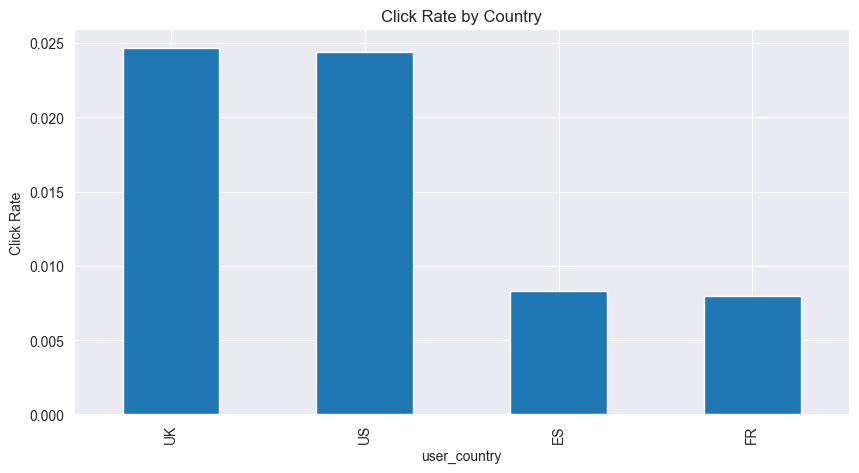

In [9]:
# Bar plot for CTR by country
country_ctr.plot(kind='bar', figsize=(10,5), title='Click Rate by Country')
plt.ylabel("Click Rate")
plt.show()

#Countries with higher CTR indicate more engaged users.
#Example: If users in USA and UK show more CTR, but users in India and Brazil show less CTR, the marketing team can:
#Focus more on these engaged regions.
#Localize content or offers for low-performing regions.


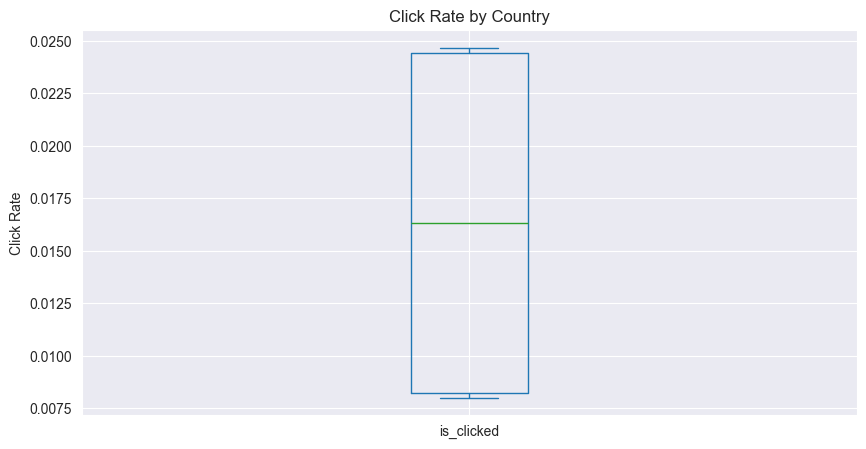

In [17]:
# Bar plot for CTR by country
country_ctr.plot(kind='box', figsize=(10,5), title='Click Rate by Country')
plt.ylabel("Click Rate")
plt.show()


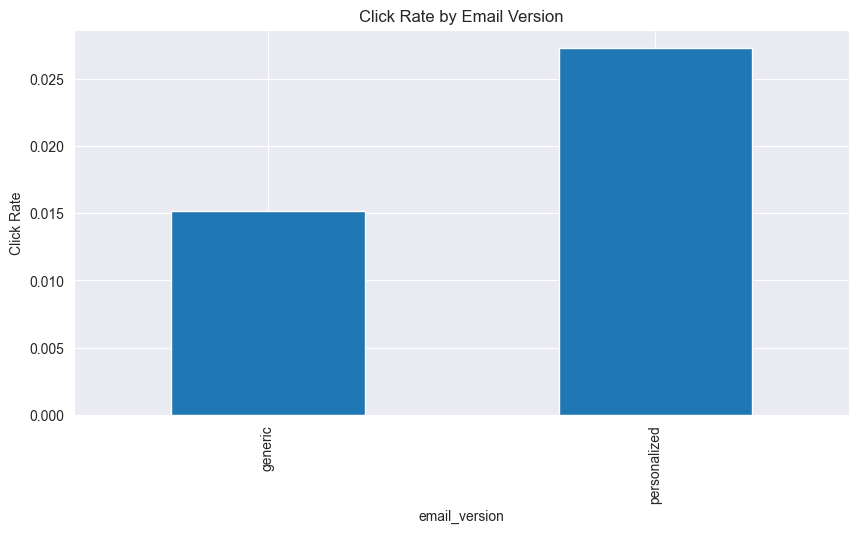

In [10]:
# Bar plot for CTR by email version
version_ctr.plot(kind='bar', figsize=(10,5), title='Click Rate by Email Version')
plt.ylabel("Click Rate")
plt.show()

#Personalized emails (e.g., “Hi John”) usually perform better than generic ones (e.g., “Hi,”).
#If CTR for personalized = 12% vs generic = 5%, this shows that adding personalization significantly boosts engagement.

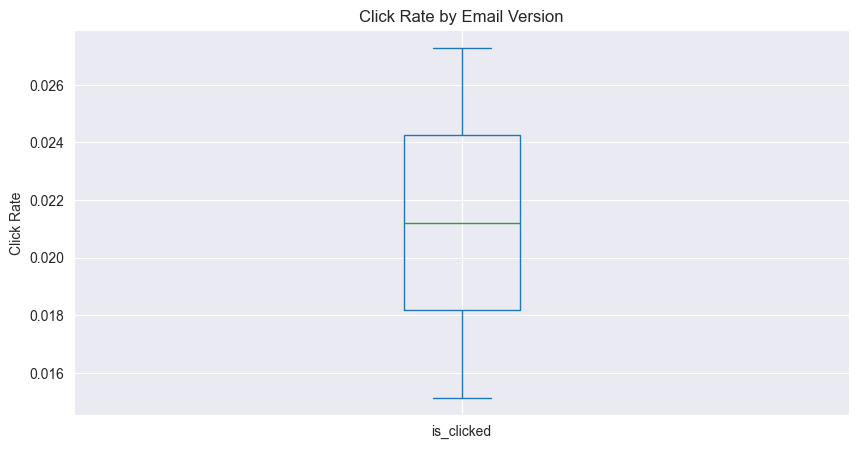

In [16]:
# Bar plot for CTR by email version
version_ctr.plot(kind='box', figsize=(10,5), title='Click Rate by Email Version')
plt.ylabel("Click Rate")
plt.show()

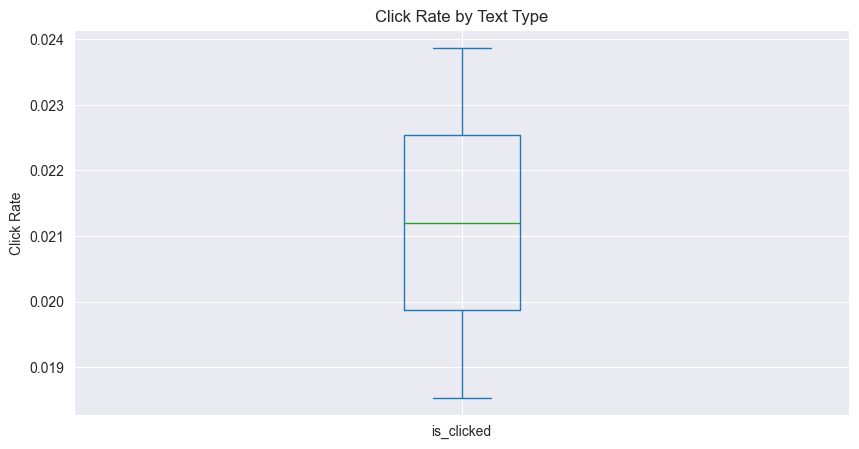

In [14]:
# Bar plot for CTR by text type
text_ctr.plot(kind='box', figsize=(10,5), title='Click Rate by Text Type')
plt.ylabel("Click Rate")
plt.show()

#Users may respond better to short and concise emails.
#Example:Short text CTR = 10%,Long text CTR = 6%
#This shows that brevity might increase link clicks.

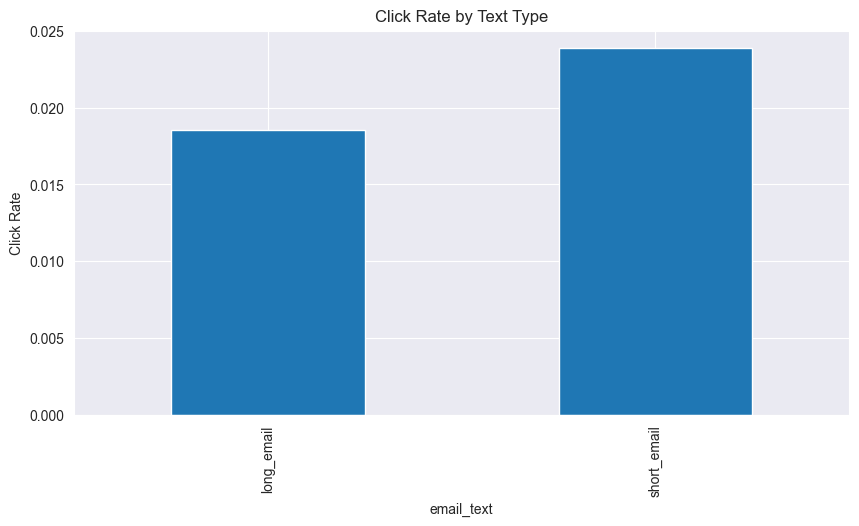

In [15]:
# Bar plot for CTR by text type
text_ctr.plot(kind='bar', figsize=(10,5), title='Click Rate by Text Type')
plt.ylabel("Click Rate")
plt.show()

In [20]:
#CTR by User Past Purchases
email_df['purchase_bins'] = pd.cut(email_df['user_past_purchases'], bins=[-1,0,1,5,10,100], labels=["0","1","2-5","6-10","10+"])
purchase_ctr = email_df.groupby("purchase_bins", observed=True)['is_clicked'].mean()
print("\nCTR by Purchase History:\n", purchase_ctr)


#Users who have made more past purchases tend to have higher CTR.
#Example:"0 past purchases" = 2%,"2–5 purchases" = 8%,"10+ purchases" = 15%
#This shows:Existing customers are more engaged and Cold users (0 purchases) are harder to convert.


CTR by Purchase History:
 purchase_bins
0       0.000504
1       0.011199
2-5     0.018509
6-10    0.036451
10+     0.069037
Name: is_clicked, dtype: float64


In [21]:
#CTR by Hour or Weekday (Optional but Powerful)
hourly_ctr = email_df.groupby("hour")['is_clicked'].mean()
weekday_ctr = email_df.groupby("weekday")['is_clicked'].mean()
print("\nCTR by Purchase History:\n",hourly_ctr)
print("\nCTR by Weekday:\n", weekday_ctr)


#Identify best time/day to send emails.
#For example:
#Highest CTR at 9 AM or 8 PM
#Weekdays like Tuesday and Thursday may outperform Monday/Friday
#Recommendation: Schedule emails for high-performing time slots.


CTR by Purchase History:
 hour
1     0.018128
2     0.016322
3     0.019523
4     0.016186
5     0.018013
6     0.017147
7     0.018284
8     0.018933
9     0.025794
10    0.028240
11    0.027128
12    0.025661
13    0.019889
14    0.020742
15    0.024907
16    0.023197
17    0.018489
18    0.016186
19    0.016575
20    0.012195
21    0.008219
22    0.019608
23    0.041379
24    0.028986
Name: is_clicked, dtype: float64

CTR by Weekday:
 weekday
Friday       0.014037
Monday       0.022906
Saturday     0.017846
Sunday       0.016751
Thursday     0.024445
Tuesday      0.024889
Wednesday    0.027620
Name: is_clicked, dtype: float64
